# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    mat_path = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'
else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    mat_path = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time
import scipy.io
import pandas as pd

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

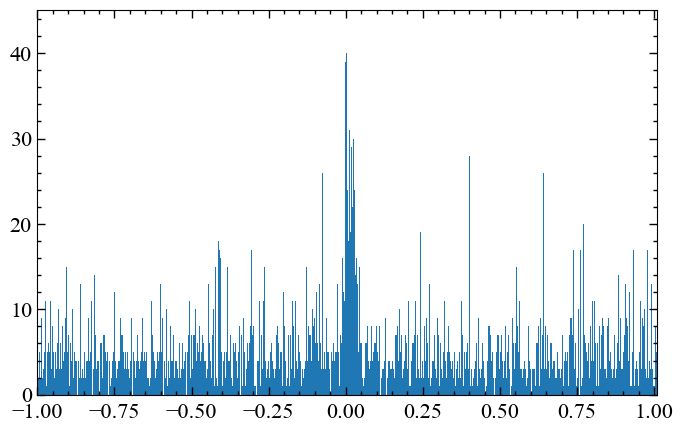

In [4]:
df_asim = pd.read_csv(mat_path+'GRB201227A.csv')
#working with [s]

tlagg_approx = -0.531
df_asim['tus'] /= 1e6
df_asim['tus'] += tlagg
tus = df_asim['tus'].to_numpy(dtype=np.float64)
binsize = 0.002 #16ms
bins = np.arange(min(tus),max(tus)+binsize,binsize)
plt.hist(tus,bins=bins)
#plt.vlines(x=-0.0293,ymin=0,ymax=50,color='r')
plt.show()

In [5]:
T0 = datetime.fromisoformat('2018-12-22T15:14:07.002390') + timedelta(seconds=tlagg_approx)#cottected_datetime_level1
df_asim = make_adr(df_asim)
df_asim.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_asim.drop(df_asim[df_asim['typ']==3].index, inplace = True) #removed valleys
df_asim.head()

,tus,dau,det,typ,erg,adr
0,-0.996780,1,1,0,502,1
1,-0.993412,1,1,0,234,1
2,-0.990720,1,1,0,35,1
3,-0.987858,1,1,0,118,1
4,-0.987400,1,1,0,243,1


In [6]:
#converting to us
df_asim['tus'] *= 1e6
tus,erg,dau,det = df_asim['tus'].to_numpy(dtype=np.float64),df_asim['erg'].to_numpy(),df_asim['dau'].to_numpy(),df_asim['det'].to_numpy()
keV,abc = convert_erg(erg,dau,det,T0)
df_asim['keV'] = keV


st,dt = get_st(df_asim),get_dt(df_asim) #st returned in us
df_asim['st']=st
df_asim['dt']=dt

flag = get_flag(df_asim)
df_asim['flag'] = flag
df_asim.drop(df_asim[get_flag(df_asim)].index,inplace=True)
df_asim.sort_values(by='tus',inplace=True,ignore_index=True)
df_asim['tus'] /= 1e6
print('Safety time: ',np.round((len(np.where(flag==True))/len(tus))*100,3), '% removed')
print('sorted by tus (s)')

Safety time:  0.018 % removed
sorted by tus (s)


In [7]:
df_asim

,tus,dau,det,typ,erg,adr,keV,st,dt,flag
0,-1.000611,1,2,0,27,2,500.4355,1.000871,0.0,False
1,-0.999945,3,2,0,167,8,4161.3776,3.000000,666.0,False
2,-0.996780,1,3,0,234,3,2456.0959,6.941461,3441.0,False
3,-0.996780,1,1,0,502,1,5634.7238,19.000000,0.0,False
4,-0.993929,1,2,0,39,2,721.1096,1.442219,6682.0,False
...,...,...,...,...,...,...,...,...,...,...
5597,1.007537,2,1,0,265,4,1925.2217,11.934516,5344.0,False
5598,1.008134,2,2,0,1690,5,31617.0975,23.646839,5087.0,False
5599,1.008134,1,3,0,263,3,2781.4463,9.251571,4019.0,False
5600,1.008223,2,3,0,91,6,861.5759,4.615759,3709.0,False


# CC

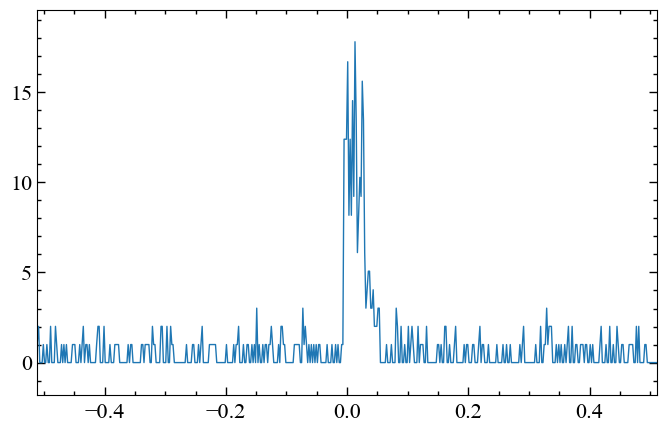

In [8]:
kw_filename = "GRB201227A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

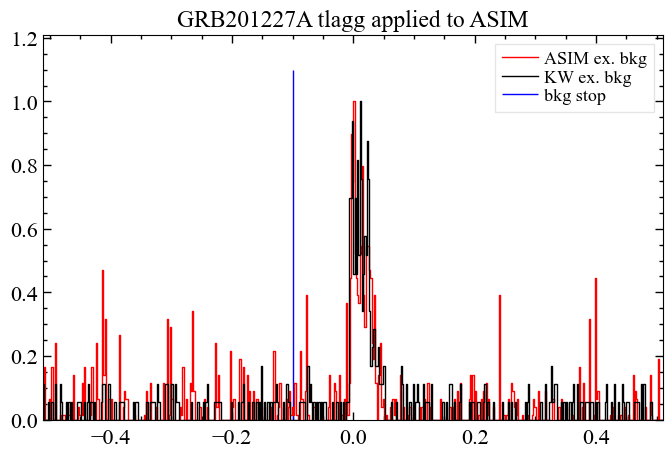

In [9]:
tus_asim = df_asim['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
j_a_stop = np.searchsorted(asim_edges,-0.10)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:j_a_stop]), 0) #removing bkg from ASIM

plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='r')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
plt.vlines(x=-0.1,ymin=0,ymax=1.1,color='blue',label='bkg stop')
plt.ylim(bottom=0)
plt.legend()
plt.title("GRB201227A tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [10]:
asim_lc = LC(time=asim_edges.astype(np.float32)[:-1]+binsize/2,counts=asim_counts.astype(np.int32),skip_checks=True)
kw_lc = LC(time=bins.astype(np.float32)[:-1]+binsize/2,counts=G3.astype(np.int32),skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

In [29]:
import os
os.getcwd()

'/Users/andreas/phys/master/GRB/xspec/ASIM/GRB181222B'

In [12]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg = CC_kw_asim.time_shift + tlagg_approx
print(f'tlagg_asim: {tlagg}')
#CC_kw_asim.plot(save=True,filename='GRB201227A_CC_KW_ASIM.pdf')
plt.show()

tlagg_asim: -0.532953125


In [29]:
tlagg

-0.532953125

## Update to df_asim

Safety time:  0.018 % removed
sorted by tus (s)


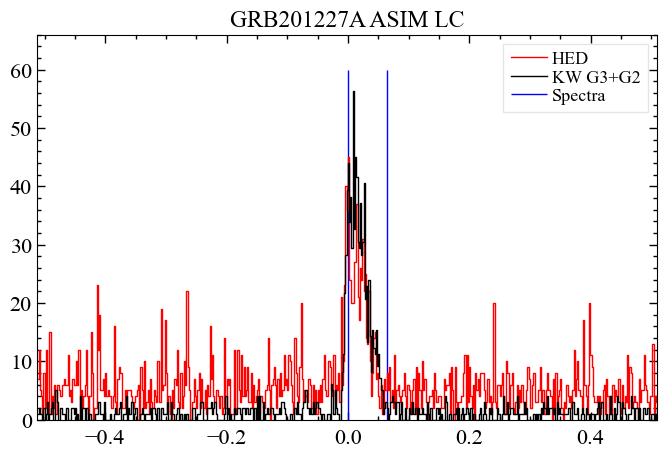

In [67]:
df_asim = pd.read_csv(mat_path+'GRB201227A.csv')
df_asim['tus'] /= 1e6
df_asim['tus'] += tlagg
tus = df_asim['tus'].to_numpy(dtype=np.float64)
binsize = 0.002 #16ms

T0 = datetime.fromisoformat('2020-12-27T15:14:07.002390') + timedelta(seconds=tlagg)#cottected_datetime_level1
df_asim = make_adr(df_asim)
df_asim.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_asim.drop(df_asim[df_asim['typ']==3].index, inplace = True) #removed valleys

#erg --> keV
df_asim['tus'] *= 1e6
tus,erg,dau,det = df_asim['tus'].to_numpy(dtype=np.float64),df_asim['erg'].to_numpy(),df_asim['dau'].to_numpy(),df_asim['det'].to_numpy()
keV,abc = convert_erg(erg,dau,det,T0)
df_asim['keV'] = keV
st,dt = get_st(df_asim),get_dt(df_asim) #st returned in us
df_asim['st']=st
df_asim['dt']=dt

flag = get_flag(df_asim)
df_asim['flag'] = flag
df_asim.drop(df_asim[get_flag(df_asim)].index,inplace=True)
df_asim.sort_values(by='tus',inplace=True,ignore_index=True)
df_asim['tus'] /= 1e6
tus = df_asim['tus'].to_numpy(dtype=np.float64)
df_asim.reset_index(inplace=True)

print('Safety time: ',np.round((len(np.where(flag==True))/len(tus))*100,3), '% removed')
print('sorted by tus (s)')


asim_counts,asim_edges = np.histogram(tus,bins=bins)
plt.step(asim_edges[:-1],asim_counts,c='red',where='post',label='HED')
plt.step(bins[:-1],G3+G2,c='black',where='post',label='KW G3+G2')
plt.vlines(x=[0,0.064],ymin=0,ymax=60,color='blue',label='Spectra')
plt.ylim(bottom=0)
plt.legend()
plt.title("GRB201227A ASIM LC")
plt.show()

In [68]:
bak_interval = [(-0.95, -0.05), (0.1, 0.95)]
burst_interval = (0.00, 0.064)
df_bkg = df_asim[(tus >= bak_interval[0][0]) & (tus <= bak_interval[0][1]) | (tus >= bak_interval[1][0]) & (tus <= bak_interval[1][1])]
df_burst = df_asim[(tus >= burst_interval[0]) & (tus <= burst_interval[1])]

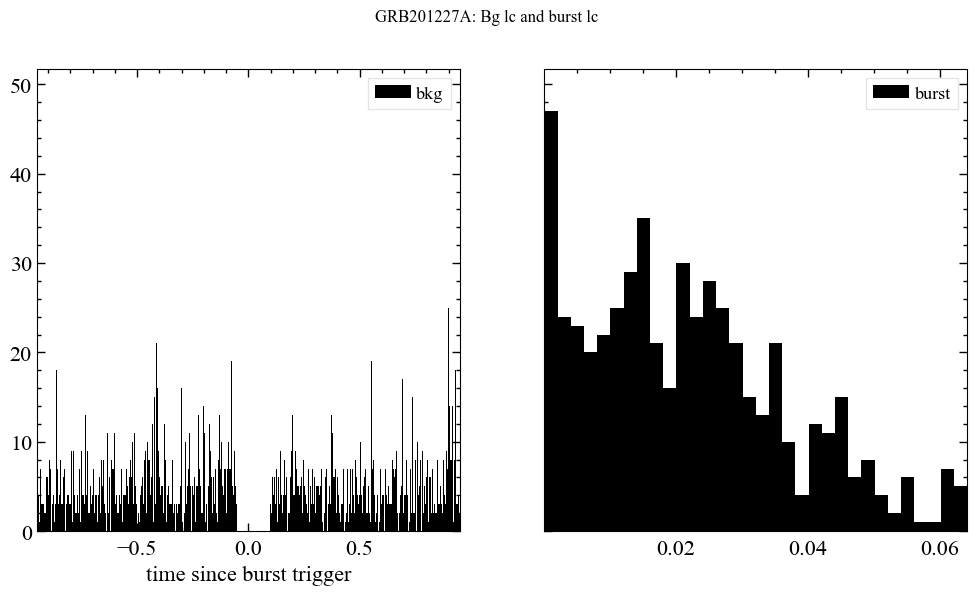

In [69]:
tus_bkg, tus_burst = df_bkg['tus'].to_numpy(), df_burst['tus'].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))
fig.suptitle('GRB201227A: Bg lc and burst lc')
ax1.hist(tus_bkg,bins=np.arange(min(tus_bkg),max(tus_bkg)+binsize,binsize),label='bkg',color='black')
ax2.hist(tus_burst,bins=np.arange(min(tus_burst),max(tus_burst)+binsize,binsize),label='burst',color='black')
#ax2.vlines(x=[0.128,0.256],ymin=0,ymax=500,color='red',label='sp3_4')
#ax2.vlines(x=[0,0.512],ymin=0,ymax=500,color='blue',label='sp1_5')
ax1.set_xlabel("time since burst trigger")
ax1.legend()
ax2.legend()
plt.show()

In [70]:
keV_burst = keV_hist(df=df_burst,time_interval='max',keV_interval='max')

initial len keV/tus: (531, 531)
Start/Stop tus interval: (9.687499999999628e-05, 0.06319387499999995)
len keV/tus: 531, 531
mean keV: 13.275
Energies binned!


In [71]:
keV_bkg = keV_hist(df=df_bkg,time_interval='max',keV_interval='max')

initial len keV/tus: (4453, 4453)
Start/Stop tus interval: (-0.949411125, 0.949737875)
len keV/tus: 4453, 4453
mean keV: 111.275
Energies binned!


# FITS

### PHA

In [86]:
df_burst['tus'].to_numpy()[-1]-df_burst['tus'].to_numpy()[0]

0.06309699999999996

In [88]:
bin_lo = keV_burst['bins_keV'].to_numpy()[:-1]
bin_hi = keV_burst['bins_keV'].to_numpy()[1:]
counts = keV_burst['counts'].to_numpy()[1:]
err = keV_burst['poisson_error_counts'].to_numpy()[1:]
print(len(bin_lo),len(bin_hi),len(counts),len(err))
print(T0)

40 40 40 40
2020-12-27 15:14:06.469437


In [90]:
PHA_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2020-12-27 20:11:36.602679','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.0631,'[s] Integration time in seconds for the PHA data'], #<float> 
'OBJECT': ['GRB201227A','Name of the observed object'], #<str> 
'RA_OBJ': [170.121,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-73.613,'[deg] Dec of source'], #<float>
'BACKFILE': ['HED_GRB201227A.bak','Background FITS file'], #<str> ('example.bak')
'RESPFILE': ['HED_GRB201227A.rsp','Response FITS file'], #<str> ('example.rsp')
'FILENAME': ['HED_GRB201227A.pha','PHA filename'] #<str>  ('example.pha')
}
generatePHA(PHA_dict=PHA_dict, counts=counts, stat_err=err, bin_lo=bin_lo, bin_hi=bin_hi)

### BAK

In [103]:
bin_lo = keV_bkg['bins_keV'].to_numpy()[:-1]
bin_hi = keV_bkg['bins_keV'].to_numpy()[1:]
counts_bkg = keV_bkg['counts'].to_numpy()[1:]
err_bkg = keV_bkg['poisson_error_counts'].to_numpy()[1:]
print(len(bin_lo),len(bin_hi),len(counts_bkg),len(err_bkg))
print(T0)

40 40 40 40
2020-12-27 15:14:06.469437


In [76]:
bak_interval

[(-0.95, -0.05), (0.1, 0.95)]

In [77]:
0.9+0.85

1.75

In [102]:
tus_bkg = df_bkg['tus'].to_numpy()
print(tus_bkg[np.searchsorted(tus_bkg,0)-1]-tus_bkg[0] + (tus_bkg[-1]-tus_bkg[np.searchsorted(tus_bkg,0)]))

1.748737


In [105]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-12-27 15:14:06.469','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.9,'[s] Start time of first background accumulation interval'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.95,'End time of second background interval accumulation'], #<float> [s]
    'EXPOSURE': [1.748737,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB201227A','Name of the observed object'], #<str> 
    'RA_OBJ': [170.121,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-73.613,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB201227A.bak','Backgorund filename'] #<str>  ('example.bak')
}
generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=counts_bkg,stat_err=err_bkg)

### RSP

In [109]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-12-27 15:14:06.469','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.00,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.0631,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB201227A','Name of the observed object'], #<str> 
    'RA_OBJ': [170.121,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-73.613,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB201227A.rsp','RSP filename'] #<str>  ('example.bak')
}

theta,phi = 77.318, -50.463

drm_fn=find_DRM_file(dir_path='/Users/andreas/phys/master/HED_DRM/',theta=theta,phi=phi)
print(drm_fn)
generateRSP(RSP_dict=rsp_dict, 
            DRM_fname=drm_fn, 
            bin_lo=bin_lo,
            bin_hi=bin_hi,
            theta=theta,
            phi=phi)

HED_drm_mats_75.00_-45.00.txt


In [110]:
keV_burst

,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.00000
1,12.58925,0,0.00000
2,15.84893,0,0.00000
3,19.95262,0,0.00000
4,25.11886,0,0.00000
5,31.62278,0,0.00000
6,39.81072,0,0.00000
7,50.11872,0,0.00000
8,63.09573,0,0.00000
9,79.43282,0,0.00000
